# Semi-Supervised Learning (SSL)

### student: Samuel BAZAZ

SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.


## Settings
On commence par importer les packages et modules nécessaires, puis on définit les différents paramètres dont les chemins d'accès pour les données:

In [182]:
############
# Packages #
############
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
import scipy.io as sio
from imageio import imread

# added packages
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from scipy.special import softmax
from sklearn import svm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from prettytable import PrettyTable

################
# Importations #
################
from helper import (
    min_span_tree, 
    build_similarity_graph, label_noise,
    build_laplacian, 
    build_laplacian_regularized, # Function to construct a regularized Laplacian from data.
    plot_classification,
    mask_labels, # Function to select a subset of labels and mask the rest
)
from helper_online_ssl import create_user_profile, online_face_recognition

from load_images import(
    load_image_data,
    plot_image_data,
    load_image_data_augmented,
    plot_image_data_augmented
)
###########
#  Paths  #
###########
root = Path(os.getcwd())
data_path = root.joinpath("data")
faces_path = data_path.joinpath("10faces")
extended_faces_path = data_path.joinpath("extended_dataset")

moon_path = str(data_path.joinpath("data_2moons_hfs.mat"))
moon_large_path = str(data_path.joinpath("data_2moons_hfs_large.mat"))

#####################
#  Hyperparameters  #
#####################
params = {}
# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 20

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'rw'

# Coefficients for C matrix for soft HFS
params['c_l'] = 0.99
params['c_u'] = 0.01

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

**Un peu de contexte:**
Avant d'attaquer l'implémentation, rappelons un le cadre derrière ce problème de SSL. La partie inductive de l'algorithme est un simple apprentissage d'un "classifier" dans laquelle on fait soit de l'interpolation (cas Hard), soit on autorise une erreur sur le train set (cas Soft) en remplaçant la contrainte explicite par une erreur empirique qui est ici le carrée d'une distance d'opérateur (où C traduit la forme quadratique associée) avec la labellisation d'entrainement. La partie transductive consiste à ajouter la Smoothness du signal sur graphe dans la loss. Le terme de Smoothness peut être vue sous deux prismes différents: c'est une approximation de l'énergie de Dirichlet sur une variété, et sa minimisation conduit à ce f soit probable vis à vis de la distribution des données et la métrique locale inférée.
Sous le prisme de la théorie du signal, il s'agit d'un terme de dénoising qui revient à garder les composantes de bases fréquences dans la décomposition de Fourier de notre signal sur graphe. Maintenant que le problème est posé, on cherche une solution harmonique d'une part pour ses propriétés qualitatives pertinentes, d'autres part car l'on dispose de formes closes. Enfin, notons que les méthodes de "manifold learning" utilisés ici sont les algorithmes Diffusion Map (DM) ou Laplacian Eigenmap (LE) en fonction du Laplacien choisi et qu'il existe d'autres méthodes comme ISOMAP qui réalise une approximation de la distance géodésique par un plus court chemin sur le graphe, ou les méthodes d'attraction répulsion comme t-SNE et UMAP.

**Fonctions implémentés:**

- **compute_hfs** résout ces problèmes pour des solutions harmoniques. 
- **two_moons_hfs** construit le graphe de similarité (ε-graph ou knn-graph) afin de passer en discret.  

In [190]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """
    num_samples = L.shape[0]
    Cl = np.unique(Y) 
    num_classes = len(Cl)-1 # on enlève 1 pour la classe des non labellisé
    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    l_idx = np.arange(len(Y))[Y != 0] #labeled
    u_idx = np.arange(len(Y))[Y == 0] #unlabeled
    
    y = np.zeros((num_samples, num_classes))
    y[l_idx, Y[l_idx].astype(int) - 1] = 1 #on labelise sous forme OneHot 
    
    ## Cas hard
    if not soft:    
        """
        Compute hard HFS.  
        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """   
        # On garde la même labellisation pour les noeud labellisé (cas Hard).
        f_l = y[l_idx]
        
        # Pour les non labelllisés on utilie l'expression du cours avec la bonne décomposition par block du Laplacien 
        Luu = L[:,u_idx][u_idx] 
        Lul = L[:,l_idx][u_idx]    

        f_u = np.linalg.pinv(Luu) @ (-1*Lul @ f_l) 
        # On réunit enfin les deux cas dans une même solution f
        f = np.zeros((num_samples, num_classes))
        f[l_idx] = f_l
        f[u_idx] = f_u
        
    ## Cas soft
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        #On construit d'abords la matrice de Confiance de la labellisation
        #Cette dernière est supposée diagonales avec seulement deux valeurs possibles:
        # c_l pour les noeuds labellisés et c_u pour les noeuds non labellisés.
        C = np.zeros(num_samples)
        c_l = params['c_l']
        c_u = params['c_u']
        C[l_idx] = c_l
        C[u_idx] = c_u
        C = np.diag(C) # on met sous forme d'une matrice diagonales
        # L'expression de la solution harmonique est enfin données dans l'énoncé:
        f = np.linalg.pinv( np.linalg.pinv(C) @ L + np.eye(num_samples)) @ y
        # Notons que l'on pourrait ajouter un état puits, utile lorsque des outliers sont présents 
        # simplement en remplaçant L par L+γ*I où γ serait le paramètre associé au puits. 

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    #on repasse d'une écriture One Hot à un vecteurs de classes pour les labels
    labels = np.argmax(f, axis=1) + 1  
    return labels, f


def two_moons_hfs(
    l=4, 
    l_noisy=1, 
    soft=False, 
    dataset=moon_path,          
    per_class=False, 
    plot=True, 
    seed=None, 
    **params
):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of "noisy" labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    per_class : bool
        If True, we select "l" labeled samples per class. Otherwise, we select "l" labeled samples in total.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    
    """
    if seed is not None:
        np.random.seed(seed)

    # Data loading
    in_data = sio.loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class=per_class)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    
    # introduce noise : on essaie de voir l'effet d'une mauvaise labellisation
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)
    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph lap_mataplacian using the parameters:
    L = build_laplacian_regularized(
        X, 
        laplacian_regularization = params['laplacian_regularization'], 
        var = params['var'], 
        eps = params['eps'],
        k = params['k'],
        laplacian_normalization = params['laplacian_normalization']
    )
    labels, f = compute_hfs(L, Y_masked, soft, **params)
    accuracy = np.mean(labels == np.squeeze(Y))

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

Utiliser un knn-graph permet de plus facilement gérer le caractère multi-échelles d'une distribution. Comme l'on cherche une à avoir une forte connexité on choisit cette approche pour nos lunes. 

Le random walk Laplacian permet ensuite de mieux rendre compte des volumes dans les différentes parties du graphe et présente un meilleur comportement au vu des résultats du TP1. On utilisera donc ce dernier dans toute la suite du TP.

k=15 est suffisant pour avoir un graphe connecté.

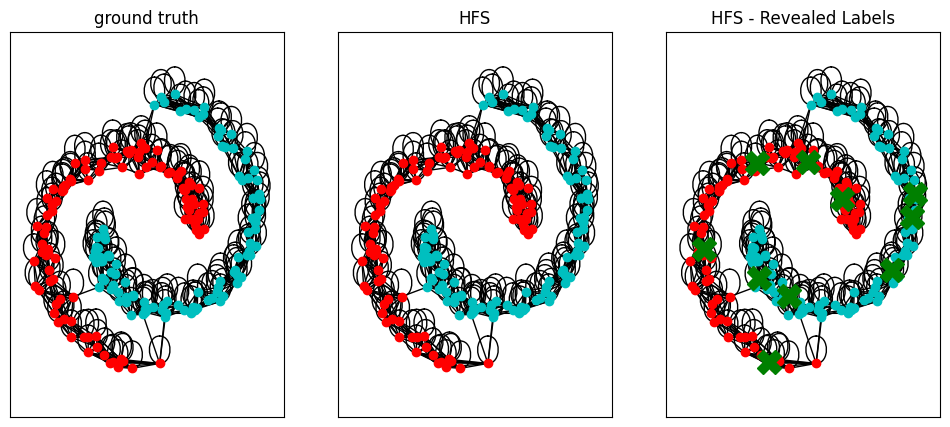

Soft=False, Accuracy=1.0


In [196]:
# Apply HFS to two-moons dataset
params['k'] = 10
params["laplacian_regularization"] = 0
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10, 
    l_noisy=0, 
    soft=False,                                
    dataset=moon_path, 
    plot=True, 
    seed=42, 
    **params
)

En prenant le bon k la classification est parfaite. Cependant lorsque le graphe de similarité est moins bon, par exemple en prenant k trop grand, on se retrouve avec une erreur de classification:

In [ ]:
params['k'] = 100
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10, 
    l_noisy=0, 
    soft=False,                                
    dataset=moon_path, 
    plot=True, 
    seed=42, 
    **params
)

Les méthodes SSL sont alors pertinente pour compenser l'imperfection des graphes de similarités, comme le montre l'amélioration de la classification suivante en prenant l=20.

In [ ]:
params['k'] = 100
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=20, 
    l_noisy=0, 
    soft=False,                                
    dataset=moon_path, 
    plot=True, 
    seed=42, 
    **params
)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

On recommence sur un échantillon plus grand, et on augmente donc k pour garder une forte connexité.

In [ ]:
params['k'] = 50
params["laplacian_regularization"] = 0
# Apply HFS to large two-moons dataset 20 times 
accuracy = np.zeros(20)
for k in range(20):
    if k > 0 : 
        plot = False
    else: 
        plot= True 
    X, Y, hard_labels, accuracy[k] = two_moons_hfs(
            l=4, 
            l_noisy=0, 
            soft=False, 
            dataset=moon_large_path, 
            plot=plot, 
            per_class=True, 
            seed=None,  
            **params
    )
print(f'Hard HFS Accuracy: Mean={np.round(accuracy.mean(),3)} Var={np.round(accuracy.var(),3)}')

Comme précédemment, avec un bon graphe de similarité la labellisation est parfaite, en l'absence d'erreurs sur les noeuds labellisés en entrée. Regardons maintenant ce que cela donne avec un moins bon graphe de similarité:

In [ ]:
params['k'] = 100
params["laplacian_regularization"] = 0
# Apply HFS to large two-moons dataset 20 times 
accuracy = np.zeros(20)
for k in range(20):
    if k > 0 : 
        plot = False
    else: 
        plot= True 
    X, Y, hard_labels, accuracy[k] = two_moons_hfs(
            l=4, 
            l_noisy=0, 
            soft=False, 
            dataset=moon_large_path, 
            plot=plot, 
            per_class=True, 
            seed=None,  
            **params
    )

print(f'Hard HFS Accuracy: Mean={np.round(accuracy.mean(),3)} Var={np.round(accuracy.var(),3)}')

Avec un graphe de similarité moins représentatif de la géométrie de notre nuage de point, il nous faut beaucoup plus de noeuds labellisés quand la taille de l'échantillon augmente pour retrouver une bonne labellisation, comme dans le cas suivant avec l=8.

In [ ]:
params['k'] = 100
params["laplacian_regularization"] = 0
# Apply HFS to large two-moons dataset 20 times 
accuracy = np.zeros(20)
for k in range(20):
    if k > 0 : 
        plot = False
    else: 
        plot= True 
    X, Y, hard_labels, accuracy[k] = two_moons_hfs(
            l=10, 
            l_noisy=0, 
            soft=False, 
            dataset=moon_large_path, 
            plot=plot, 
            per_class=True, 
            seed=None,  
            **params
    )

print(f'Hard HFS Accuracy: Mean={np.round(accuracy.mean(),3)} Var={np.round(accuracy.var(),3)}')

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

On se replace dans le cas sous optimal k=20, de manière à ce que la labellisation puisse apporter un gain de performance.

________Hard_______


<Figure size 640x480 with 0 Axes>

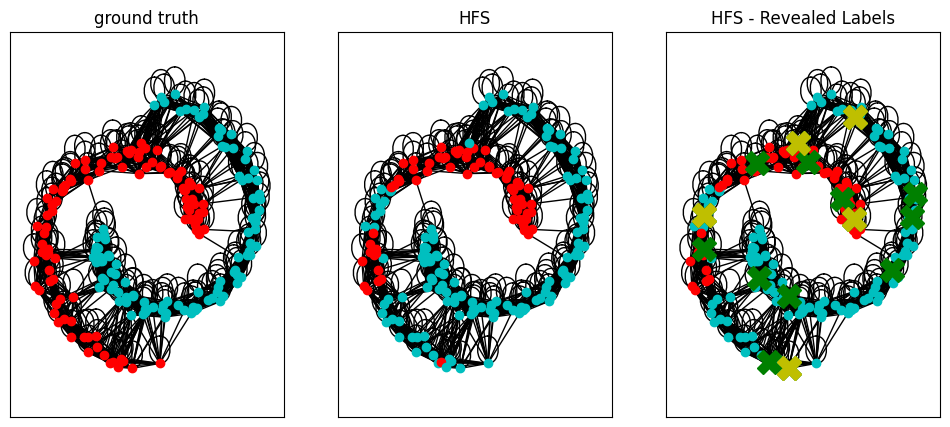

Soft=False, Accuracy=0.84
________Soft_______


<Figure size 640x480 with 0 Axes>

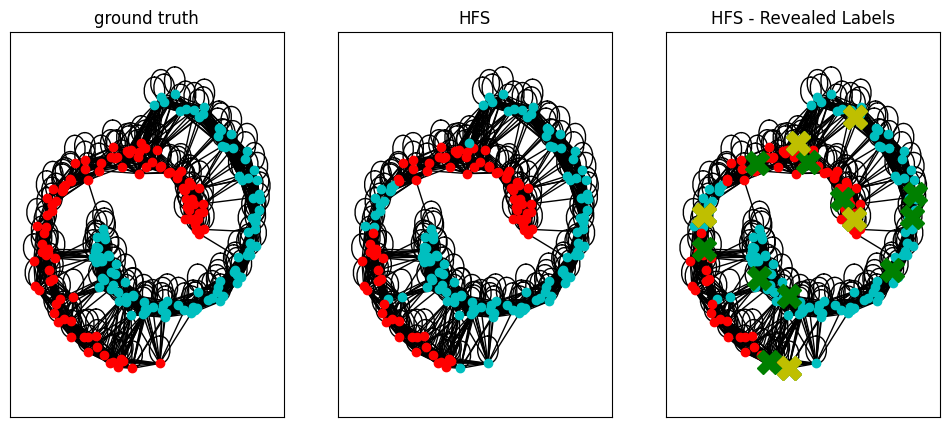

Soft=True, Accuracy=0.915


In [193]:
###############################
# Comparing hard and soft HFS #
###############################
# Choose parameters 
params['k'] = 20

# Hard
print("________Hard_______")
params["laplacian_regularization"] = 0
plt.clf()
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10, l_noisy=5, soft=False, dataset=moon_path, plot=True, seed=42, **params
)

# Soft
print("________Soft_______")
params["laplacian_regularization"] = 1
params["c_l"] = 0.8
params["c_u"] = 0.2
plt.clf()
X, Y, soft_labels, soft_accuracy = two_moons_hfs(
    l=10, l_noisy=5, soft=True, dataset=moon_path, plot=True, seed=42, **params
)

Lorsque le graphe de similarité est sous optimal ie la géométrie apprise n'est pas une très bonne approximation de la variété sous jacente, la méthode Soft améliore la robustesse aux erreurs de labellisation. Hélas cette approche peut aussi dégrader la labellisation lorsque le graphe de similarité est très bon, surtout lorsque l'on prend c_l grand, car le terme de Smoothness est alors dominé en ordre de grandeur par le terme de regression, contrairement au cas Hard, dans lequel il n'y a pas de treadoff.

In [ ]:
# Choose parameters 
params['k'] = 10

# Hard
print("________Hard_______")
params["laplacian_regularization"] = 0
plt.clf()
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10, l_noisy=5, soft=False, dataset=moon_path, plot=True, seed=42, **params
)

# Soft
print("________Soft_______")
params["laplacian_regularization"] = 1
params["c_l"] = 0.8
params["c_u"] = 0.2
plt.clf()
X, Y, soft_labels, soft_accuracy = two_moons_hfs(
    l=10, l_noisy=5, soft=True, dataset=moon_path, plot=True, seed=42, **params
)

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

**Preprocesing**
Suite à plusieurs essais, on constate que l'augmentation des contrastes améliore la classification, avec notamment l'utilisation du "Contrast Limited Adaptive Histogram Equalization". Un passe bas très local par un noyau Gaussien permet d'avoir de meilleures performances qu'un floutage médian, sûrement pour les mêmes raisons. 

**Graphe de similarité**
Premièrement, il y a un caractère multiéchelle des images dans lequels les variations de luminance d'une texture et d'un contour ne sont pas du même ordre de grandeur. Il est donc préférable pour assurer la connexité d'utiliser un knn-graph.
On remarque ensuite expérimentalement que les performances sont rapidement dégradés lorsque l'on augmente le nombre de liaisons, et que k=12 donne de bons résultats. Comme on n'est pas assuré d'avoir une forte connexité dans ce cas, il est possible que cette configuration donne de bonnes performances car elle faciliterait la segmentation du visage à travers différentes composantes connexes, bien que cela ne soit pas recommandé pour obtenir une bonne représentation spectrale.


Samples in Small dataset:


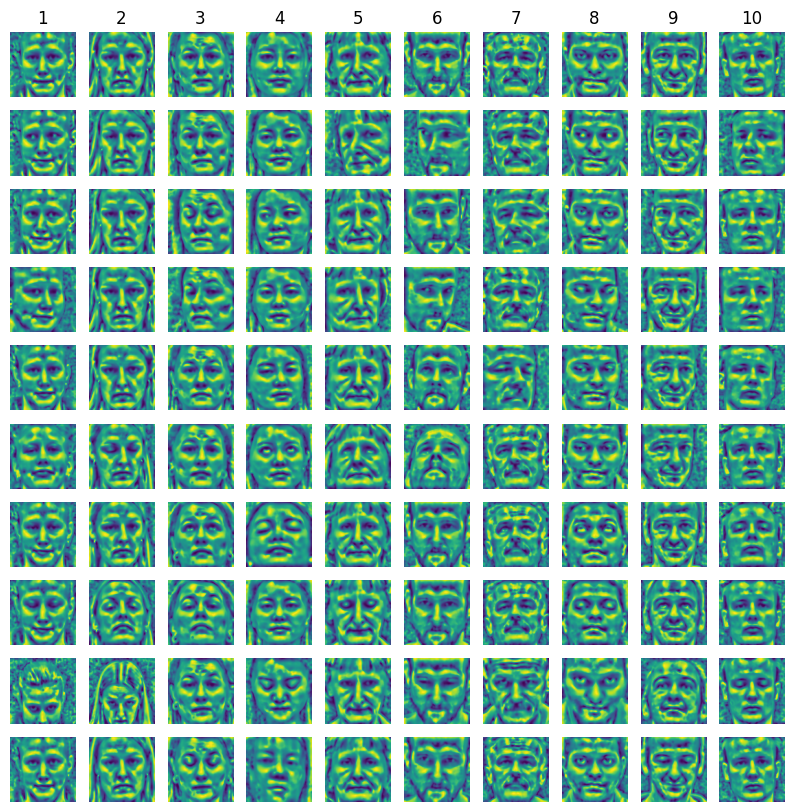

Percent of missing data in Small dataset: 60.0


<Figure size 640x480 with 0 Axes>

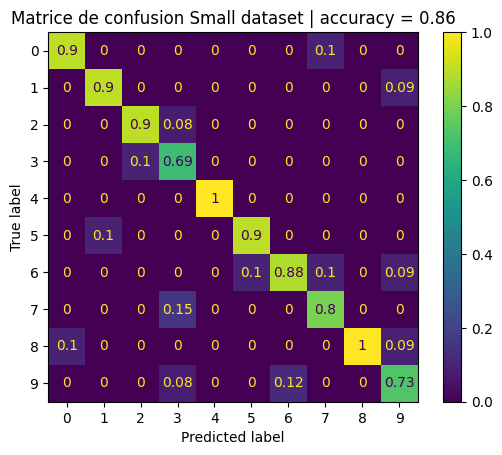


Samples in Augmented dataset:
(weird images have a border)


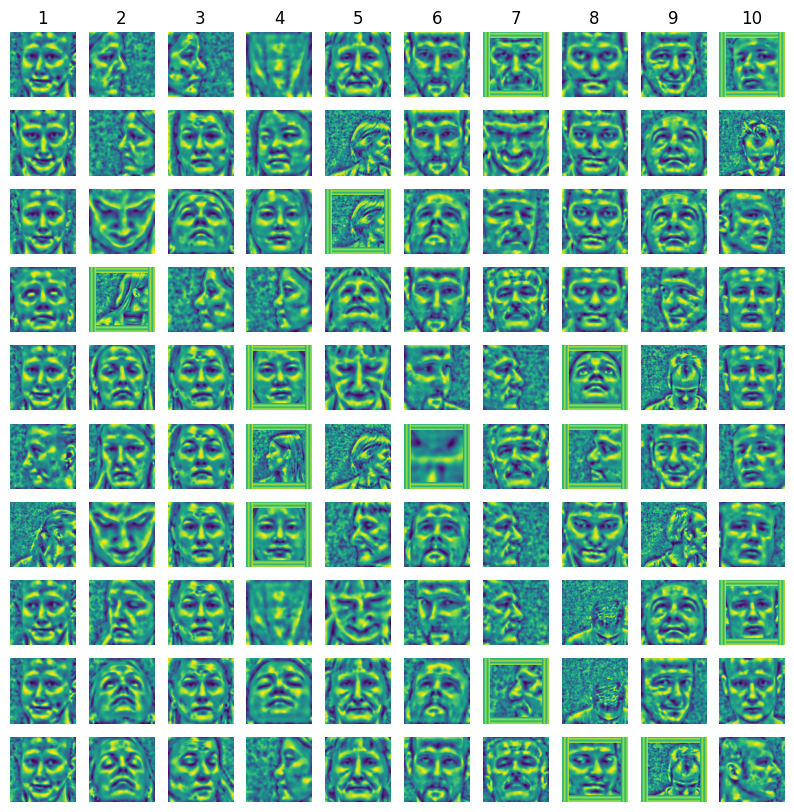

Percent of missing data in Augmented dataset: 92.0


<Figure size 640x480 with 0 Axes>

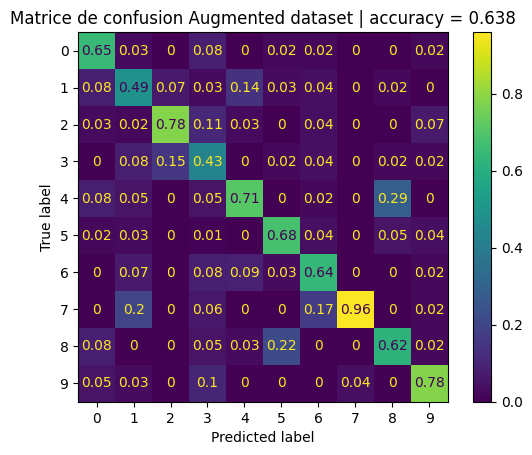

In [89]:
###############
#  Fonctions  #
###############
# Preprocessing
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    # Bilateral filtering 
    image = cv2.bilateralFilter(image, 9, 75, 75)
      
    # Histogram Equalization
    # image = cv2.equalizeHist(image)
    clahe = cv2.createCLAHE(tileGridSize=(8,8)) 
    image = clahe.apply(image)

    # Blurring
    image = cv2.GaussianBlur(image, (3, 3), 0)
    #image = cv2.medianBlur(image,3)
    
    # Reformat
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

# HFS
def faces_soft_hfs(imgs, mask_y):
    """
    Define parameters for face recognition with HFS
    """
    params_face_rec = {}
    params_face_rec['laplacian_regularization'] = 1
    params_face_rec['var'] = 500
    # params_face_rec['eps'] = 0.001
    params_face_rec['eps'] = None
    params_face_rec['k'] = 12
    # params_face_rec['k'] = None
    params_face_rec['laplacian_normalization'] = 'rw'
    params_face_rec['c_l'] = 0.7
    params_face_rec['c_u'] = 0.3
    
    L = build_laplacian_regularized(imgs, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])
    return compute_hfs(L, mask_y, soft=True, **params_face_rec)
     
def plot_classif(y_true, y_pred, dataset_name = "Small dataset"):
    accuracy = np.equal(y_pred, y_true).mean()
    cmat = confusion_matrix(y_true, y_pred)
    sum_lab = cmat.sum(0)
    sum_lab[sum_lab==0]=1
    cmat = np.round(cmat / sum_lab,2)
    plt.clf()
    ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=np.arange(10)).plot()
    plt.title(f"Matrice de confusion {dataset_name} | accuracy = {np.round(accuracy, 3)}")
    plt.show()

def faces_hfs_pipeline(load_funct, seed, dataset_name = "Small dataset"):
    np.random.seed(seed)
    print(f"\nSamples in {dataset_name}:")
    imgs, y_true, mask_y = load_funct(preprocess_image)
    if load_funct.__name__ == "load_image_data_augmented":
        print("(weird images have a border)")
        for weird_image_index in [6, 9, 24, 31, 43, 47, 53, 55, 57, 63, 79, 86, 97, 98]:
            img = imgs[weird_image_index]
            n = int(np.sqrt(len(img)))
            img = img.reshape(n, n)
            img[:10] = 1
            img[:10:2] = 0
            img[-10:] = 1
            img[-10::2] = 0
            img[:, :10] = 1
            img[:, :10:2] = 0
            img[:, -10:] = 1
            img[:, -10::2] = 0
            imgs[weird_image_index] = img.flatten()
            
    plot_image_data(imgs[:100])
    missing_ratio = 100 * np.mean(mask_y == 0)
    print(f"Percent of missing data in {dataset_name}: {np.round(missing_ratio,2)}")
    y_pred, _= faces_soft_hfs(imgs, mask_y)
    plot_classif(y_true, y_pred, dataset_name=dataset_name)
    
############
#  Script  #
############

# 10 images per person
faces_hfs_pipeline(load_image_data, 42, dataset_name = "Small dataset")

# 50 images per person
faces_hfs_pipeline(load_image_data_augmented, 42, dataset_name = "Augmented dataset")

### Question 2.1 - How did you manage to label more than two classes?

**compute_hfs** autorise plus de deux classes en faisant une classification one vs all puis en renvoyant la classe la plus probable. En effet en utilisant le Laplacien normalisé, le f que l'on obtient est une liste de vecteur de probabilité, et il suffit d'utiliser argmax pour récupérer le résultat souhaité.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person).
 
Suite à une étape de fine tuning, on obtient les métriques suivantes:

|              | **Small Dataset** | **Augmented Dataset** |
|--------------|-------------------|-----------------------|
| **Accuracy** | 0.86              | 0.64                 


Ces résultats sont perfectibles notamment avec un meilleur preprocessing et graphe de similarité. |

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performanc

La classification est grandement perturbée pour la base augmentée, en raison d'un nombre conséquent de mauvais exemples. En effets,  des images sont mal cadrées et peu représentatives d'un visage. Or la méthode que l'on étudie ici a pour objectif d'estimer la métrique locale d'une variété qui serait associée ici aux images de visages. Il est donc logique que cette approximation se détériore lorsque les images utilisé pour l'inférence s'éloigne de la variété ciblée.
Il faut donc dans notre cas favoriser la qualité à la quantité, surtout en raison de la localité des méthodes DM et LE.e?

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.
 
Pour l'implémentation on utilise le pseudo code donnée en annexe.

In [141]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl["laplacian_regularization"] = 0.05
params_online_ssl["var"] = 1000
params_online_ssl["eps"] = None
params_online_ssl["k"] = 15
params_online_ssl["laplacian_normalization"] = "rw"

class IncrementalKCenters:
    def __init__(
        self,
        labeled_faces,
        labels,
        label_names,
        max_num_centroids=50,
        thrs=0.1
    ):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert set(labels) == set(
            range(1, 1 + self.n_labels)
        ), "Initially provided faces should be labeled in [1, max]"
        assert len(labeled_faces) == len(
            labels
        ), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels

        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None # 
        self.V = None # multiplicité d'un centroide
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

        # threshold for "Unknown"
        self.thrs = thrs

    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """
        #  Compute the centroids distances
        self.centroids_distances = sd.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[
            0 : self.n_labeled_faces, 0 : self.n_labeled_faces
        ] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.

        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample

        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert self.image_dimension == len(face), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            ## On calcule c_1 et c_2:
            # Pour traiter les distances entre centroides on se ramènes à une liste de distances puis on récupères les
            cdistances = self.centroids_distances.ravel()
            # Puis on récupère les positions associée au distances minimal
            idx_list = np.argsort(cdistances)

            # On parcours ensuite ces distances et on récupère les positions associée dans la matrice initiale
            # en utilisant le nombre de centroïdes
            nc = self.centroids_distances.shape[0]
            for idx in idx_list:
                c_1 = idx // nc
                c_2 = idx % nc
                # On arrête dès que l'on a au moins c2 ou c1 qui n'est pas dans taboo
                if (c_1 not in self.taboo) or (c_2 not in self.taboo):
                    break
                    
            ## On calcule c_rep et c_add en fonction des cas conformément au pseudo code:
            if self.taboo[c_2]: # c2 in b.
                c_rep = c_2
                c_add = c_1
            elif self.V[c_2] <= self.V[c_1]:  # la multiplicité de c2 est plus petite.
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1
            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] += self.V[c_add]  #on additionne les multiplicité suite au merge
            self.centroids[c_add, :] = face #on ajoute la nouvelle image au graphe
            self.V[c_add] = 1 # on reset la multiplicité de c_add
            """
            Update the matrix containing the distances.
            """
            # On calcul les distance avec le nouveau centroid c_add associé à la nouvelle image 
            dist_row = sd.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf # la nouvelle image est labellisé ce qui conduit à mettre un +inf vis a vis d'elle même
            # On met ensuite à jours la matrice de distances avec les valeurs calculés précédement. 
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            # On garde en mémoire la dernière image pour réaliser une classification dessus.
            self.last_face = c_add
            
        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            # Ici on a pas de merge à réaliser et la multiplicité est déjà initialisé
            # On ajoute donc face aux centroides.
            self.centroids = np.vstack([self.centroids, face])
            # Puis on ajoute 0 à Y car les nouvelles images sont non labellisées.
            self.Y = np.append(self.Y, 0)

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """
        
        # On calcule la matrice de multiplicité V:
        # A l'initialisation il n'y a que les images labellisée
        # Chaque centroïde est de multiplicité 1, 
        # et on prend la dernière image d'apprentissage pour initialiser last_face
        if self.init:
            V = np.eye(self.centroids.shape[0])
            self.last_face = self.centroids.shape[0] - 1
        # Dans le cas contraire on utilise les multiplicité pour contruire V:
        else:
            V = np.diag(self.V)

        # On contruit la matrice d'adjacence associé au graphe de similarité des centroides:
        Ac = build_similarity_graph(
            self.centroids,
            params_online_ssl["var"],
            params_online_ssl["eps"],
            params_online_ssl["k"],
        )
        # Puis on utilise la multiplicité V pour mettre à jours les dégrées afin de prendre en compte 
        # le nombre d'images associé à chaque centroïde :
        Wq = V @ Ac @ V

        # Maintenant que l'on a une matrice d'adjacence représentative de nos données on calcul le laplacien 
        L = build_laplacian(Wq, params_online_ssl["laplacian_normalization"])
        # On ajoute une régularisation associée à un état puits:
        Q = L + params_online_ssl["laplacian_regularization"] * np.eye(Wq.shape[0])
        
        # On calcule enfin la solution Hamonique du problème Hard:
        bestlabel, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # On récupère ensuite les scores et on se ramène à des probabilité en utilisant softmax
        scores = softmax(f[self.last_face])
        
        # On labellise comme "Unknown" dans le cas où la classification est trop mauvaise
        # par trop mauvaise on entend que l'lagorithme "hésite" trop 
        # ce qui correspond ici à un seuil sur la différence de score entre le premier et le deuxième.
        # Dans le cas où il n'y a qu'une seule classe on utilise un seuil absolue
        sorted_scores = np.sort(scores)
        if len(sorted_scores)==1:
            indice_confiance = sorted_scores[-1]-0.5
        else:
            indice_confiance = sorted_scores[-1]-sorted_scores[-2]
        
        if indice_confiance<self.thrs: # cas Unknown
            return [("Unknown", 1)]
        return list(zip(self.label_names, scores))

In [ ]:
create_user_profile("Samuel", video_filename=None)  # choose your names here :)

In [ ]:
create_user_profile("GrumpySam", video_filename=None) 

In [ ]:
online_face_recognition(['Samuel', "GrumpySam"], IncrementalKCenters)

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`
 
La reconnaissance fonctionne difficilement au début puis avec l'apprentissage non supervisé et un peu d'attente il devient très performant:

Au point où il me reconnait parmi des proches!

### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


Pour les scores on utilise softmax afin de se ramener à des probabilités.
Ensuite, la labellisation en "Unknown" on utilise un indice de confiance, qui pour le cas où l'on a une seule classe est l'écart avec l'aléatoire ( p-0.5 ) et qui dans le cas contraire est l'écrat entre les deux plus grandes probabilités. En effet ces indices capturent la confiance du classifier dans la labellisation et lorsque il y a plusieurs classes, cela mesure l"hésitation" entre les deux principales.

### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

Pour ajouter une nouvelle classe on modifie la mise à jours de V dans la partie "Update data structures", comme suit. 
Malheurement ce type de d'ajout automatique peut conduire à créer une classe sur un individu déjà labellisé et ainsi détériorer grandement la classification. Il faudrait donc ajouter une procédure pour limiter ce cas pathologique.

In [31]:
class IncrementalKCenters_autoBob:
    def __init__(
        self,
        labeled_faces,
        labels,
        label_names,
        max_num_centroids=50
    ):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert set(labels) == set(
            range(1, 1 + self.n_labels)
        ), "Initially provided faces should be labeled in [1, max]"
        assert len(labeled_faces) == len(
            labels
        ), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels

        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None # 
        self.V = None # multiplicité d'un centroide
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """
        #  Compute the centroids distances
        self.centroids_distances = sd.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[
            0 : self.n_labeled_faces, 0 : self.n_labeled_faces
        ] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.

        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample

        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert self.image_dimension == len(face), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            ## On calcule c_1 et c_2:
            # Pour traiter les distances entre centroides on se ramènes à une liste de distances puis on récupères les
            cdistances = self.centroids_distances.ravel()
            # Puis on récupère les positions associée au distances minimal
            idx_list = np.argsort(cdistances)

            # On parcours ensuite ces distances et on récupère les positions associée dans la matrice initiale
            # en utilisant le nombre de centroïdes
            nc = self.centroids_distances.shape[0]
            for idx in idx_list:
                c_1 = idx // nc
                c_2 = idx % nc
                # On arrête dès que l'on a au moins c2 ou c1 qui n'est pas dans taboo
                if (c_1 not in self.taboo) or (c_2 not in self.taboo):
                    break
                    
            ## On calcule c_rep et c_add en fonction des cas conformément au pseudo code:
            if self.taboo[c_2]: # c2 in b.
                c_rep = c_2
                c_add = c_1
            elif self.V[c_2] <= self.V[c_1]:  # la multiplicité de c2 est plus petite.
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1
            """
            MODIFICATION
            Update data structures: self.centroids and self.V
            """
            # On ajoute une nouvelle classe si elle apparait plus de 100 fois
            if not self.taboo[c_rep] and self.V[c_rep] > 100:
                # On ajoute la nouvelle classe et on met à jours les attributs
                new_c = np.max(self.Y) + 1
                self.label_names += [f"AutoBob {new_c}"]
                self.n_labeled_faces += 1
                self.n_labels += 1
                # On oublie pas de changer l'état des centroides c_rep et c_add
                self.Y[c_rep] = new_c
                self.Y[c_add] = new_c
                self.taboo[c_rep] = True
                self.taboo[c_add] = True
                
            self.V[c_rep] += self.V[c_add]  #on additionne les multiplicité suite au merge
            self.centroids[c_add, :] = face #on ajoute la nouvelle image au graphe
            self.V[c_add] = 1 # on reset la multiplicité de c_add
   

            
            """
            Update the matrix containing the distances.
            """
            # On calcul les distance avec le nouveau centroid c_add associé à la nouvelle image 
            dist_row = sd.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf # la nouvelle image est labellisé ce qui conduit à mettre un +inf vis a vis d'elle même
            # On met ensuite à jours la matrice de distances avec les valeurs calculés précédement. 
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            # On garde en mémoire la dernière image pour réaliser une classification dessus.
            self.last_face = c_add
            
        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            # Ici on a pas de merge à réaliser et la multiplicité est déjà initialisé
            # On ajoute donc face aux centroides.
            self.centroids = np.vstack([self.centroids, face])
            # Puis on ajoute 0 à Y car les nouvelles images sont non labellisées.
            self.Y = np.append(self.Y, 0)

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """
        
        # On calcule la matrice de multiplicité V:
        # A l'initialisation il n'y a que les images labellisée
        # Chaque centroïde est de multiplicité 1, 
        # et on prend la dernière image d'apprentissage pour initialiser last_face
        if self.init:
            V = np.eye(self.centroids.shape[0])
            self.last_face = self.centroids.shape[0] - 1
        # Dans le cas contraire on utilise les multiplicité pour contruire V:
        else:
            V = np.diag(self.V)

        # On contruit la matrice d'adjacence associé au graphe de similarité des centroides:
        Ac = build_similarity_graph(
            self.centroids,
            params_online_ssl["var"],
            params_online_ssl["eps"],
            params_online_ssl["k"],
        )
        # Puis on utilise la multiplicité V pour mettre à jours les dégrées afin de prendre en compte 
        # le nombre d'images associé à chaque centroïde :
        Wq = V @ Ac @ V

        # Maintenant que l'on a une matrice d'adjacence représentative de nos données on calcul le laplacien 
        L = build_laplacian(Wq, params_online_ssl["laplacian_normalization"])
        # On ajoute une régularisation associée à un état puits:
        Q = L + params_online_ssl["laplacian_regularization"] * np.eye(Wq.shape[0])
        
        # On calcule enfin la solution Hamonique du problème Hard:
        bestlabel, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # On récupère ensuite les scores et on se ramène à des probabilité en utilisant softmax
        scores = softmax(f[self.last_face])
        
        # On labellise comme "Unknown" dans le cas où la classification est trop mauvaise
        # par trop mauvaise on entend que l'lagorithme "hésite" trop 
        # ce qui correspond ici à un seuil sur la différence de score entre le premier et le deuxième.
        # Dans le cas où il n'y a qu'une seule classe on utilise un seuil absolue
        sorted_scores = np.sort(scores)
        if len(sorted_scores)==1:
            indice_confiance = sorted_scores[-1]-0.5
        else:
            indice_confiance = sorted_scores[-1]-sorted_scores[-2]
        
        if indice_confiance<0.1: # cas Unknown
            return [("Unknown", 1)]
        return list(zip(self.label_names, scores))

Ici l'algorithme préfère créer une nouvelle classe plutôt que m'associer à ma version enfant, ce qui se comprend. Par contre la classe "AutoBob 5" s'est construite sur deux individus. En conséquence, la classification devient instable car "AutoBob 5" fait la moyenne de deux visages pour la classification.

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

#### Answer
Pour Les comparaisons, nous utiliserons la base simple de visage et un SVM avec un noyau Gaussien comme méthode supervisé.
Comme les classes sont équilibrées par construction, on se contentera de l'accuracy comme métrique de performance.

In [184]:
##########
#  Data  #
##########
print("___Data___")
# On récupère les données après preprocessing 
np.random.seed(42)  
imgs, y_true, mask_y = load_image_data(preprocess_image)
# plot_image_data(imgs[:100])

# On sépare les données de train et de test 
X_train, X_test, idx_train, idx_test = train_test_split(imgs, np.arange(y_true.shape[0]), test_size=0.20, random_state=42)

y_true_train = y_true[idx_train]
y_true_test = y_true[idx_test]

# On créé un mask adapté pour le test 
mask_y_test = mask_y.copy()
mask_y_test[idx_test] = 0
mask_y_test_all_train = y_true.copy()
mask_y_test_all_train[idx_test] = 0

# On sépare les données de labellisées et non labellisées 
X_train_l = X_train[np.where(mask_y_train != 0)]
X_train_u = X_train[np.where(mask_y_train == 0)]
y_true_train_l =  y_true_train[np.where(mask_y_train != 0)]

print('N=', X_train.shape[0])
print('m=', X_test.shape[0])
print('l=', X_train_l.shape[0])
print('u=', X_train_u.shape[0])

###############
#  Functions  #
###############

f_score=lambda y_pred_test:  np.round(accuracy_score(y_true_test, y_pred_test),3)
def score_SVM(X,y, name = "l", train_score=False):
    SVM = svm.SVC()
    SVM.fit(X, y)
    if train_score:
        y_pred = SVM.predict(X)
        plot_classif(y, y_pred, dataset_name = f"SVM train {name}")
        return np.round(accuracy_score(y, y_pred),3)
    y_pred = SVM.predict(X_test)
    plot_classif(y_true_test, y_pred, dataset_name = f"SVM {name}")
    return f_score(y_pred)
    
init_tab1=lambda : PrettyTable(["Modele", "Type", "Accuracy"])



___Data___
N= 80
m= 20
l= 34
u= 46


#### Supervised VS Semi-Supervised

<Figure size 640x480 with 0 Axes>

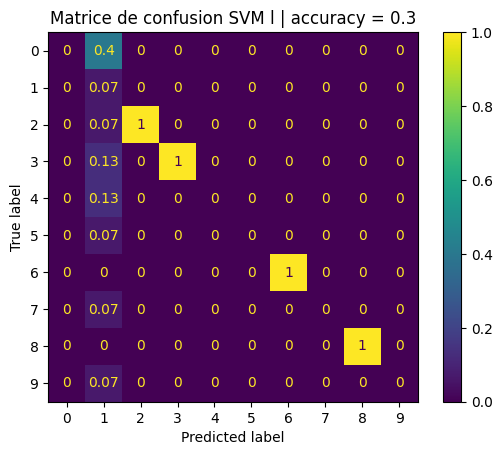

<Figure size 640x480 with 0 Axes>

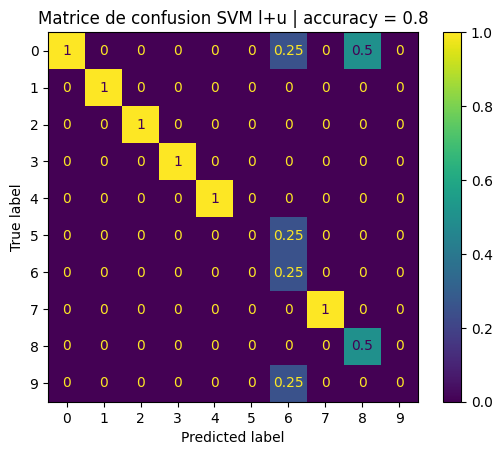

[ 4  3  9  2  5 10  4 10  2 10  9  8  4  4 10  5  7  4  3  2]
+--------------------------------+------+----------+
|             Modele             | Type | Accuracy |
+--------------------------------+------+----------+
|            SVM on l            |  SL  |   0.3    |
|           SVM on l+u           |  SL  |   0.8    |
|           HFS on l+u           | SSL  |   0.5    |
| HFS on l+u, all train revealed | SSL  |   0.85   |
+--------------------------------+------+----------+


In [185]:
tab_sl_vs_ssl = init_tab1()

## Supervised on l
tab_sl_vs_ssl.add_row(
    ["SVM on l", 
     "SL", 
     score_SVM(X_train_l, y_true_train_l, name = "l")
    ]
)

## Supervised on l+u
tab_sl_vs_ssl.add_row(
    ["SVM on l+u", 
     "SL", 
     score_SVM(X_train, y_true_train, name = "l+u")
    ]
)


## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
# plot_classif(y_true_test, y_pred[idx_test], dataset_name= f"HFS l+u")
print(y_pred[idx_test])
tab_sl_vs_ssl.add_row(
    ["HFS on l+u", 
     "SSL", 
     f_score(y_pred[idx_test])
    ]
)

## SSL on l+u all train revealed
y_pred, _= faces_soft_hfs(imgs, mask_y_test_all_train)
# plot_classif(y_true_test, y_pred[idx_test], dataset_name= f"HFS l+u all revealed")
tab_sl_vs_ssl.add_row(
    ["HFS on l+u, all train revealed", 
     "SSL", 
     f_score(y_pred[idx_test])
    ]
)

print(tab_sl_vs_ssl)

On a évidement une amélioration de la classification lorsque l'on révèle toutes les labellisation pour le train set. Ensuite, on remarque que l'apprentissage non supervisé améliore les performances dans tous les cas comparé au SVM et ce prbablement en raison du caractère transductif du HFS.

#### Inductive vs Transductive

<Figure size 640x480 with 0 Axes>

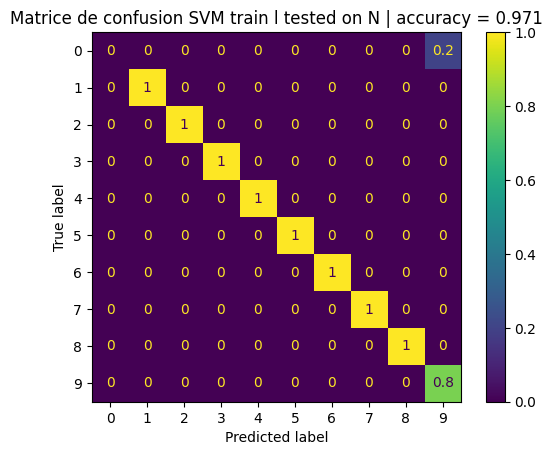

<Figure size 640x480 with 0 Axes>

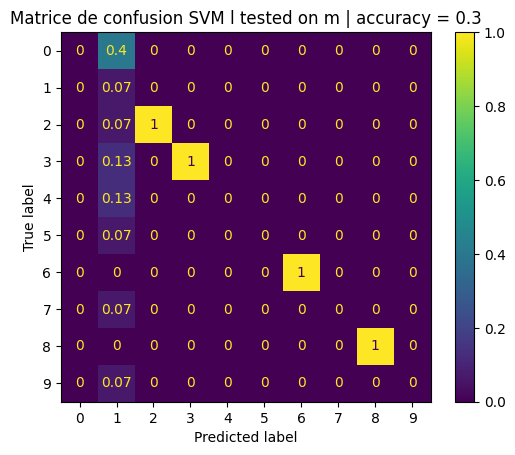

+------------------------+------+----------+
|         Modele         | Type | Accuracy |
+------------------------+------+----------+
|  SVM on l tested on N  |  SL  |  0.971   |
| HFS on l+u tested on N | SSL  |  0.8125  |
|  SVM on l tested on m  |  SL  |   0.3    |
| HFS on l+u tested on m | SSL  |   0.5    |
+------------------------+------+----------+


In [186]:
tab_ind_vs_trans = init_tab1()

### Train error
## Supervised on l 
tab_ind_vs_trans.add_row(
    ["SVM on l tested on N", 
     "SL", 
     score_SVM(X_train_l, y_true_train_l, name = "l tested on N", train_score=True)
    ]
)


## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
# plot_classif(y_true_train, y_pred[idx_train], dataset_name= f"HFS l+u tested on N")
tab_ind_vs_trans.add_row(
    ["HFS on l+u tested on N", 
     "SSL", 
     accuracy_score(y_true_train, y_pred[idx_train])
    ]
)


### Test error
## Supervised on l
tab_ind_vs_trans.add_row(
    ["SVM on l tested on m", 
     "SL", 
     score_SVM(X_train_l, y_true_train_l, name = "l tested on m")
    ]
)


## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
# plot_classif(y_true_test, y_pred[idx_test], dataset_name= f"HFS l+u tested on m")
tab_ind_vs_trans.add_row(
    ["HFS on l+u tested on m", 
     "SSL", 
     f_score(y_pred[idx_test])
    ]
)

print(tab_ind_vs_trans)

L'approche inductive semble présenter un plus grand risque d'overfitting que la démarche transductive: l'erreur d'entrainement est plus faible mais l'erreur de généralisation y est plus grand. Pour le comprendre, on remarque que l'objectif du HFS arbitre entre la qualité de la régression et une proximité avec les données connue ce qui limite le risque d'interpolation par une régularisation géométrique qui orientant la génération, améliore la prédiction. Notons cependant que le SVM a eu moins de données pour l'entrainement, d'où la nécessité de tester avec toutes les données.

#### Supervised vs Semi-supervised and Inductive vs Transductive

<Figure size 640x480 with 0 Axes>

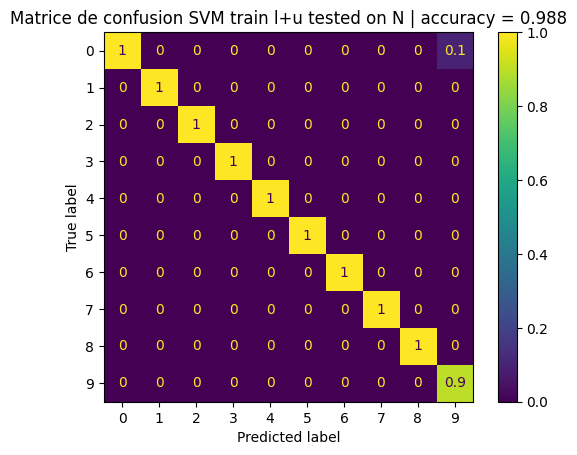

<Figure size 640x480 with 0 Axes>

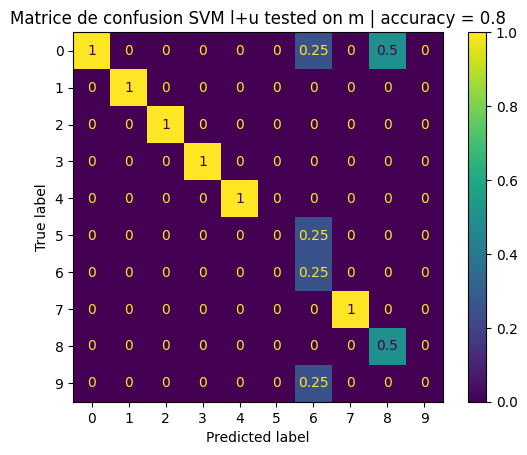

+--------------------------------------+------+----------+
|                Modele                | Type | Accuracy |
+--------------------------------------+------+----------+
|        SVM on l+u tested on N        |  SL  |  0.988   |
|        HFS on l+u tested on N        | SSL  |  0.8125  |
| HFS on l+u all revealed, tested on N | SSL  |   1.0    |
|        SVM on l+u tested on m        |  SL  |   0.8    |
|        HFS on l+u tested on m        | SSL  |   0.5    |
| HFS on l+u all revealed, tested on m | SSL  |   0.85   |
+--------------------------------------+------+----------+


In [188]:
tab_vs_vs = init_tab1()

### Train error
## Supervised on l 
tab_vs_vs.add_row(
    ["SVM on l+u tested on N", 
     "SL", 
     score_SVM(X_train, y_true_train, name = "l+u tested on N", train_score=True)
    ]
)


## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
# plot_classif(y_true_train, y_pred[idx_train], dataset_name= f"HFS l+u tested on N")
tab_vs_vs.add_row(
    ["HFS on l+u tested on N", 
     "SSL", 
     accuracy_score(y_true_train, y_pred[idx_train])
    ]
)

## SSL on l+u all train revealed
y_pred, _= faces_soft_hfs(imgs, mask_y_test_all_train)
# plot_classif(y_true_train, y_pred[idx_train], dataset_name= f"HFS l+u all tested on N")
tab_vs_vs.add_row(
    ["HFS on l+u all revealed, tested on N", 
     "SSL", 
     accuracy_score(y_true_train, y_pred[idx_train])
    ]
)


### Test error
## Supervised on l+u
tab_vs_vs.add_row(
    ["SVM on l+u tested on m", 
     "SL", 
     score_SVM(X_train, y_true_train, name = "l+u tested on m")
    ]
)


## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
# plot_classif(y_true_test, y_pred[idx_test], dataset_name= f"HFS l+u tested on m")
tab_vs_vs.add_row(
    ["HFS on l+u tested on m", 
     "SSL", 
     f_score(y_pred[idx_test])
    ]
)


## SSL on l+u all train revealed
y_pred, _= faces_soft_hfs(imgs, mask_y_test_all_train)
# plot_classif(y_true_train, y_pred[idx_train], dataset_name= f"HFS l+u all tested on m")
tab_vs_vs.add_row(
    ["HFS on l+u all revealed, tested on m", 
     "SSL", 
     f_score(y_pred[idx_test])
    ]
)
print(tab_vs_vs)

Comment précédement, la généralisation est meilleure pour le SVM lorsque l'on ajoute les données non labellisées. 
L'overfitting est présent aussi pour l'HFS si toutes les labels sont révélés et les performances sont encore une fois comparables.
Dans l'ensemble, le SSL performe mieux lorsque il y a des données avec labellisation manquante à disposition.

#### Online vs Batch

Pour le SSL online on initialise avec les images labellisée puis on ajoute petit à petit les images non labellisées.
Pour que l'algorithme online ne soit pas quantized pour l'instant, on augmente le nombre de centroides maximum à être égal au nombre total de données.

<Figure size 640x480 with 0 Axes>

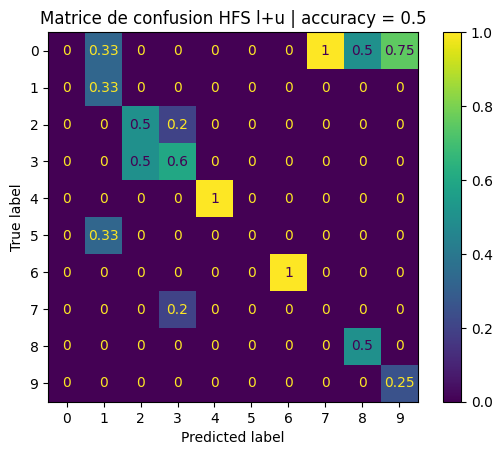

+------------------------------------+--------+----------+
|               Modele               |  Type  | Accuracy |
+------------------------------------+--------+----------+
|             HFS on l+u             | Batch  |   0.5    |
| online HFS on l+u, no quantization | Online |   0.55   |
+------------------------------------+--------+----------+


In [189]:
tab_online_batch = init_tab1() 

## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
plot_classif(y_true_test, y_pred[idx_test], dataset_name= f"HFS l+u")

tab_online_batch.add_row(
    ["HFS on l+u", 
     "Batch", 
     f_score(y_pred[idx_test])
    ]
)

## SSL online
model = IncrementalKCenters(X_train_l, y_true_train_l.astype(int), np.arange(1,11), max_num_centroids=imgs.shape[0], thrs=0.01)

# Apprentissage non supervisé online
for img_t in X_train_u:
    model.online_ssl_update_centroids(img_t)

# Apprentissage non supervisé online, test
y_pred_test = np.zeros(X_test.shape[0])
for i,img_t in enumerate(X_test):
    model.online_ssl_update_centroids(img_t)
    label_scores = model.online_ssl_compute_solution()
    scores = [ll[1] for ll in label_scores]
    y_pred_test[i] = np.argmax(scores)+1
    
tab_online_batch.add_row(
    ["online HFS on l+u, no quantization", 
     "Online", 
     f_score(y_pred_test)
    ]
)
    
# On reconstruit la prédiction 
print(tab_online_batch)

En l'abscence de quantization l'algorithme online est très mauvais, sûrement en raisons d'un plus fort biais de la part de la base d'entraînement, et d'un volume de données trop faible.

#### Exact vs Quantized

<Figure size 640x480 with 0 Axes>

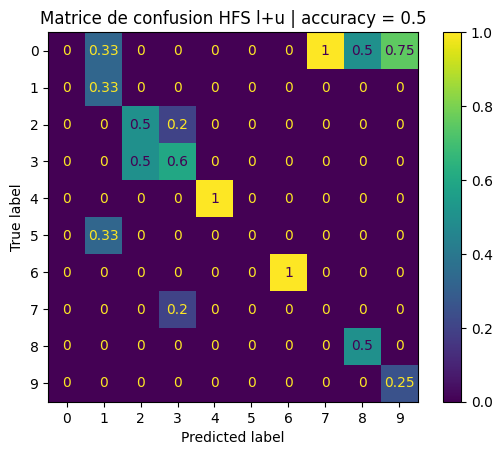

+--------------------------------------+------------------+----------+
|                Modele                |       Type       | Accuracy |
+--------------------------------------+------------------+----------+
|              HFS on l+u              |      Exact       |   0.5    |
| online HFS on l+u, with quantization | Online Quantized |   0.3    |
+--------------------------------------+------------------+----------+


In [187]:
tab_quantized = init_tab1()

## SSL on l+u
y_pred, _= faces_soft_hfs(imgs, mask_y_test)
plot_classif(y_true_test, y_pred[idx_test], dataset_name= f"HFS l+u")

tab_quantized.add_row(
    ["HFS on l+u", 
     "Exact", 
     f_score(y_pred[idx_test])
    ]
)

## SSL online Quantized
model = IncrementalKCenters(X_train_l, y_true_train_l.astype(int), np.arange(1,11), max_num_centroids=X_train_l.shape[0], thrs=0.03)

# Apprentissage non supervisé online
for img_t in X_train_u:
    model.online_ssl_update_centroids(img_t)

# Apprentissage non supervisé online, test
y_pred_test = np.zeros(X_test.shape[0])
for i,img_t in enumerate(X_test):
    model.online_ssl_update_centroids(img_t)
    label_scores = model.online_ssl_compute_solution()
    scores = [ll[1] for ll in label_scores]
    y_pred_test[i] = np.argmax(scores)+1
    
tab_quantized.add_row(
    ["online HFS on l+u, with quantization", 
     "Online Quantized", 
     f_score(y_pred_test)
    ]
)
    
# On reconstruit la prédiction 
print(tab_quantized)

Etonnement une quantization n'est pas synonyme d'une perte de performance, bien que les résultats dépendent du seuil choisit pour la classe "Unknown".
Aussi, il y a une nuance à apporter: les données d'entrainement sont ici de bonne qualité. Ainsi, il serait pertinent d'étudier la robustesse des deux approches face à des outliers.

#### Conclusion
Nous avons pu mettre en lumière comment la combinaison de la représentation spectrale avec des méthodes classiques de ML offre un paradigme puissant pour obtenir des algorithmes qui tirent profit de données non labellisés. Il faut tout de même être vigilant sur les données manipulées pour que l'apprentissage de variété soit pertinent. Les algorithmes online ont montrés de vrais performances sur la reconnaissance de caméra et les résultats modérés de la section précédente semblent est liés à une différence de volume dans les données d'apprentissages. Enfin, les méthodes SSL ouvrent le champs à nombre d'expérimentations possibles, entre le choix de la loss supervisé et le modèle génératif pour la partie non supervisé. Cela offre de plus la possibilité d'introduire des contraintes géométriques pour des procédures historiquement dénué de modélisations, et donc d'avantage de contôle sur la production des résultats. Il est tout à fait envisageable d'utiliser cette approche pour obtenir une cohérence avec certaines contraintes comme les lois de la physique par exemple.